# RAPIDS SVR - CV 0.830
This notebook is a RAPIDS SVR starter notebook which achieves CV 0.830 and LB ???. (Let's submit to LB and see what score it achieves).

In this notebook, we extract text embeddings from 6 Hugging Face models. We **do not** finetune any LLM. The 6 LLM that we use here are models directly downloaded from Hugging Face (in notebook [here][1]) as is. Each of these model can accept token lengths of at least 1024 as discussed [here][3]. Therefore we can input the full essay instead of breaking into 512 chunks.

We extract 6 sets of embeddings and concatenate them into 5376 features! Afterward we use RAPIDS SVR to quickly train a 15-Fold support vector regression model on Kaggle's 2xT4 GPUs.

Then we apply threshold post process to convert the regression outputs into the 6 possible target labels of 1, 2, 3, 4, 5, 6 as discussed by MPWare [here][2]

[1]: https://www.kaggle.com/code/cdeotte/download-huggingface-models
[2]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/502279
[3]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/498571

# Fix RAPIDS Installation
To make RAPIDS work in a Kaggle notebook we need to do one of the following:
* Downgrade Pandas to 1.X
* Pip install the latest RAPIDS

I will do the first option since it is faster and RAPIDS v23.08.00 is recent enough for our SVR in this notebook. An example of pip install recent RAPIDS v24.02.00 is [here][1]

[1]: https://www.kaggle.com/code/premsagar/rapids-cudf-pandas-on-kaggle

In [1]:
!pip install --find-links /kaggle/input/downgrade-pandas /kaggle/input/downgrade-pandas/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Looking in links: /kaggle/input/downgrade-pandas
Processing /kaggle/input/downgrade-pandas/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompat

# Load Libraries and Data

In [2]:
import polars as pl



In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import numpy as np, gc, re 
import pandas as pd 

train = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv")
train['paragraph'] = train['full_text'].str.split('\n\n')
print("Train shape",train.shape)
display(train.head())
print()

test = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv")
test['paragraph'] = test['full_text'].str.split('\n\n')

print("Test shape",test.shape)
display(test.head())

Train shape (17307, 4)


,essay_id,full_text,score,paragraph
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ..."
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu..."



Test shape (3, 3)


,essay_id,full_text,paragraph
0,000d118,Many people have car where they live. The thin...,[Many people have car where they live. The thi...
1,000fe60,I am a scientist at NASA that is discussing th...,[I am a scientist at NASA that is discussing t...
2,001ab80,People always wish they had the same technolog...,[People always wish they had the same technolo...


# Stratified 15 K Fold

In [4]:
from sklearn.model_selection import StratifiedKFold

FOLDS = 15
train["fold"] = -1
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
for fold,(train_index, val_index) in enumerate(skf.split(train,train["score"])):
    train.loc[val_index,"fold"] = fold
print('Train samples per fold:')
train.fold.value_counts().sort_index()

Train samples per fold:


0     1154
1     1154
2     1154
3     1154
4     1154
5     1154
6     1154
7     1154
8     1154
9     1154
10    1154
11    1154
12    1153
13    1153
14    1153
Name: fold, dtype: int64

# Preprocess

In [5]:
def count_sentences(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return len(sentences), [len(sentence.split()) for sentence in sentences]

In [6]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

train['full_text'] = train['full_text'].apply(dataPreprocessing)
test['full_text'] = test['full_text'].apply(dataPreprocessing)
train

,essay_id,full_text,score,paragraph,fold
0,000d118,many people have car where they live. the thin...,3,[Many people have car where they live. The thi...,10
1,000fe60,i am a scientist at nasa that is discussing th...,3,[I am a scientist at NASA that is discussing t...,12
2,001ab80,people always wish they had the same technolog...,4,[People always wish they had the same technolo...,3
3,001bdc0,"we all heard about venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",2
4,002ba53,"dear, state senator this is a letter to argue ...",3,"[Dear, State Senator, This is a letter to argu...",6
...,...,...,...,...,...
17302,ffd378d,"the story "" the challenge of exploing venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",14
17303,ffddf1f,technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,14
17304,fff016d,if you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...,13
17305,fffb49b,"in ""the challenge of exporing venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",2


# Generate Embeddings

In [7]:
from transformers import AutoModel,AutoTokenizer
import torch, torch.nn.functional as F
from tqdm import tqdm

In [8]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [9]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df,tokenizer,max_length):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

# Extract Embeddings

In [10]:
def get_embeddings(model_name='', max_length=1024, batch_size=32, compute_train=True, compute_test=True, path = "/kaggle/input/download-huggingface-models/"):

    global train, test

    DEVICE = "cuda:1" # EXTRACT EMBEDDINGS WITH GPU #2

    disk_name = path + model_name.replace("/","_")
    model = AutoModel.from_pretrained( disk_name , trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained( disk_name , trust_remote_code=True)

    ds_tr = EmbedDataset(train, tokenizer, max_length)
    embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr,
                            batch_size=batch_size,
                            shuffle=False)
    ds_te = EmbedDataset(test, tokenizer, max_length)
    embed_dataloader_te = torch.utils.data.DataLoader(ds_te,
                            batch_size=batch_size,
                            shuffle=False)
    
    model = model.to(DEVICE)
    model.eval()

    # COMPUTE TRAIN EMBEDDINGS
    all_train_text_feats = []
    if compute_train:
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = model(input_ids=input_ids,attention_mask=attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)

    # COMPUTE TEST EMBEDDINGS
    all_test_text_feats = []
    if compute_test:
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = model(input_ids=input_ids,attention_mask=attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_test_text_feats.extend(sentence_embeddings)
        all_test_text_feats = np.array(all_test_text_feats)
    all_test_text_feats = np.array(all_test_text_feats)

    # CLEAR MEMORY
    del ds_tr, ds_te
    del embed_dataloader_tr, embed_dataloader_te
    del model, tokenizer
    del model_output, sentence_embeddings, input_ids, attention_mask
    gc.collect()
    torch.cuda.empty_cache()

    # RETURN EMBEDDINGS
    return all_train_text_feats, all_test_text_feats

In [11]:
# def get_embeddings512(model_name='', max_length = 512, batch_size=32, compute_train=True, compute_test=True):

#     global train, test

#     DEVICE = "cuda:1" # EXTRACT EMBEDDINGS WITH GPU #2
#     path = "/kaggle/input/huggingface-512-model/"
#     disk_name = path + model_name.replace("/","_")
#     model = AutoModel.from_pretrained( disk_name , trust_remote_code=True)
#     tokenizer = AutoTokenizer.from_pretrained( disk_name , trust_remote_code=True)

#     # Define sliding window function
#     def sliding_window(text, window_size=512, stride=256):
#         segments = []
#         start_positions = []
#         for i in range(0, len(text), stride):
#             segment = text[i:i+window_size]
#             segments.append(segment)
#             start_positions.append(i)
#         return segments, start_positions

#     ds_tr = EmbedDataset(train, tokenizer, max_length)  
#     embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr,
#                             batch_size=batch_size,
#                             shuffle=False)
#     ds_te = EmbedDataset(test, tokenizer, max_length) 
#     embed_dataloader_te = torch.utils.data.DataLoader(ds_te,
#                             batch_size=batch_size,
#                             shuffle=False)
    
#     model = model.to(DEVICE)
#     model.eval()

#     # COMPUTE TRAIN EMBEDDINGS
#     all_train_text_feats = []
#     if compute_train:
#         for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
#             input_ids = batch["input_ids"].to(DEVICE)
#             attention_mask = batch["attention_mask"].to(DEVICE)
#             segments, _ = sliding_window(input_ids)  # Apply sliding window
#             for segment in segments:
#                 with torch.no_grad():
#                     with torch.cuda.amp.autocast(enabled=True):
#                         model_output = model(input_ids=segment, attention_mask=attention_mask)
#                 sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
#                 # Normalize the embeddings
#                 sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
#                 sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
#                 all_train_text_feats.extend(sentence_embeddings)
#     all_train_text_feats = np.array(all_train_text_feats)

#     # COMPUTE TEST EMBEDDINGS
#     all_test_text_feats = []
#     if compute_test:
#         for batch in embed_dataloader_te:
#             input_ids = batch["input_ids"].to(DEVICE)
#             attention_mask = batch["attention_mask"].to(DEVICE)
#             segments, _ = sliding_window(input_ids)  # Apply sliding window
#             for segment in segments:
#                 with torch.no_grad():
#                     with torch.cuda.amp.autocast(enabled=True):
#                         model_output = model(input_ids=segment, attention_mask=attention_mask)
#                 sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
#                 # Normalize the embeddings
#                 sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
#                 sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
#                 all_test_text_feats.extend(sentence_embeddings)
#         all_test_text_feats = np.array(all_test_text_feats)

#     # CLEAR MEMORY
#     del ds_tr, ds_te
#     del embed_dataloader_tr, embed_dataloader_te
#     del model, tokenizer
#     del model_output, sentence_embeddings, input_ids, attention_mask
#     gc.collect()
#     torch.cuda.empty_cache()

#     # RETURN EMBEDDINGS
#     return all_train_text_feats, all_test_text_feats


In [12]:
# EMBEDDINGS TO LOAD/COMPUTE
# PARAMETERS = (MODEL_NAME, MAX_LENGTH, BATCH_SIZE)
# CHOOSE LARGEST BATCH SIZE WITHOUT MEMORY ERROR

models = [
    ('microsoft/deberta-base', 1024, 32),
    ('microsoft/deberta-large', 1024, 8),
    ('microsoft/deberta-v3-large', 1024, 8),
    ('allenai/longformer-base-4096', 1024, 32),
    ('google/bigbird-roberta-base', 1024, 32),
    ('google/bigbird-roberta-large', 1024, 8),
]

In [13]:
path = "/kaggle/input/essay-embeddings-v1/"
all_train_embeds = []
all_test_embeds = []

for (model, max_length, batch_size) in models:
    name = path + model.replace("/","_") + ".npy"
    if os.path.exists(name):
        _, test_embed = get_embeddings(model_name=model, max_length=max_length, batch_size=batch_size, compute_train=False)
        train_embed = np.load(name)
        print(f"Loading train embeddings for {name}")
    else:
        print(f"Computing train embeddings for {name}")
        train_embed, test_embed = get_embeddings(model_name=model, max_length=max_length, batch_size=batch_size, compute_train=True)
        np.save(name, train_embed)
    all_train_embeds.append(train_embed)
    all_test_embeds.append(test_embed)

del train_embed, test_embed

Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-base.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-large.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/microsoft_deberta-v3-large.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/allenai_longformer-base-4096.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/google_bigbird-roberta-base.npy
Loading train embeddings for /kaggle/input/essay-embeddings-v1/google_bigbird-roberta-large.npy


In [14]:
# models512 = [
# #     ('FacebookAI/roberta-base', 512), 
# #     ('google-bert/bert-base-uncased', 512),
#     ('xlnet/xlnet-large-cased', 512),
#     ('xlnet/xlnet-base-cased', 512),
# ]

In [15]:
# path = "/kaggle/input/essay-embeddings/essay-embeddings/"

# for (model, max_length) in models512:
#     name = path + model.replace("/","_") + ".npy"
#     if os.path.exists(name):
#         _, test_embed = get_embeddings512(model_name=model,max_length=max_length, compute_train=False)
#         train_embed = np.load(name)
#         print(f"Loading train embeddings for {name}")
#     else:
#         print(f"Computing train embeddings for {name}")
#         train_embed, test_embed = get_embeddings512(model_name=model,max_length=max_length, compute_train=True)
#         np.save(name, train_embed)
#     all_train_embeds.append(train_embed)
#     all_test_embeds.append(test_embed)

# del train_embed, test_embed

# Combine Feature Embeddings

In [16]:
all_train_embeds = np.concatenate(all_train_embeds,axis=1)
all_test_embeds = np.concatenate(all_test_embeds,axis=1)

gc.collect()
print('Our concatenated train embeddings have shape', all_train_embeds.shape )

Our concatenated train embeddings have shape (17307, 5376)


768

In [17]:
print(all_train_embeds.shape)
len(all_train_embeds[all_train_embeds>0])

(17307, 5376)


47425933

# Add new feature

In [18]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape)

for i in range(6):
    train[f'deberta_oof_{i}'] = deberta_oof[:, i]
train

(17307, 6)


,essay_id,full_text,score,paragraph,fold,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,many people have car where they live. the thin...,3,[Many people have car where they live. The thi...,10,0.013380,0.608218,0.370559,0.007214,0.000358,0.000270
1,000fe60,i am a scientist at nasa that is discussing th...,3,[I am a scientist at NASA that is discussing t...,12,0.001425,0.128012,0.850459,0.019771,0.000243,0.000090
2,001ab80,people always wish they had the same technolog...,4,[People always wish they had the same technolo...,3,0.001275,0.002111,0.029406,0.461900,0.499130,0.006177
3,001bdc0,"we all heard about venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",2,0.001438,0.016373,0.546403,0.431593,0.003959,0.000235
4,002ba53,"dear, state senator this is a letter to argue ...",3,"[Dear, State Senator, This is a letter to argu...",6,0.006661,0.110362,0.855064,0.026926,0.000613,0.000375
...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" the challenge of exploing venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",14,0.078924,0.904081,0.015016,0.000987,0.000496,0.000496
17303,ffddf1f,technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,14,0.000640,0.003798,0.127668,0.859217,0.008399,0.000277
17304,fff016d,if you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...,13,0.018603,0.961708,0.018690,0.000611,0.000187,0.000201
17305,fffb49b,"in ""the challenge of exporing venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",2,0.380589,0.613714,0.004515,0.000549,0.000302,0.000330


In [19]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

In [20]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np
# vectorizer_word = TfidfVectorizer(
#             #tokenizer=lambda x: x,
#             preprocessor=lambda x: x,
#             #token_pattern=None,
#             strip_accents='unicode',
#             analyzer = 'word',
#             ngram_range=(2,6),
#             min_df=0.01, # modified for words
#             max_df=0.95,
#             sublinear_tf=True,
# )
# train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
# dense_matrix = train_tfid.toarray()
# df = pd.DataFrame(dense_matrix)
# tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
# df.columns = tfid_columns

In [21]:
# df_values = df.values

In [22]:
# df_values

In [23]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer_cnt = CountVectorizer(
#             tokenizer=lambda x: x,
#             preprocessor=lambda x: x,
#             token_pattern=None,
#             strip_accents='unicode',
#             analyzer = 'word',
#             ngram_range=(2,3),
#             min_df=0.10,
#             max_df=0.85,
# )
# train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
# dense_matrix = train_tfid.toarray()
# df_count = pd.DataFrame(dense_matrix)
# tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df_count.columns))]
# df_count.columns = tfid_columns

In [24]:
# df_count_values = df_count.values

In [25]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_count_values = scaler.fit_transform(df_count_values)

In [26]:
# import spacy
# import re

# nlp = spacy.load("en_core_web_sm")

# with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
#     english_vocab = set(word.strip().lower() for word in file)
    
# def count_spelling_errors(text):
#     doc = nlp(text)
#     lemmatized_tokens = [token.lemma_.lower() for token in doc]
#     spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
#     return spelling_errors

In [27]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Tính số lượng từ 
# def unique_word_count(text):
#     return len(set(text.split()))

# # Tính độ dài của văn bản
# def text_length(text):
#     return len(text.split())

# # Áp dụng cho tập dữ liệu huấn luyện và kiểm tra
# train['unique_word_count'] = train['full_text'].apply(unique_word_count)
# train['text_length'] = train['full_text'].apply(text_length)
# # train['miss_spelling'] = train['full_text'].apply(count_spelling_errors)
# train['sentence_count'], train['sentence_lengths'] = zip(*train['full_text'].apply(count_sentences))
# # train['max_sentence_length'] = train['sentence_lengths'].apply(lambda x: np.max(x) if x else 0)
# # train['min_sentence_length'] = train['sentence_lengths'].apply(lambda x: np.min(x) if x else 0)
# # train['sentence_length_std'] = train['sentence_lengths'].apply(lambda x: np.std(x) if x else 0)


# test['unique_word_count'] = test['full_text'].apply(unique_word_count)
# test['text_length'] = test['full_text'].apply(text_length)
# # test['miss_spelling'] = test['full_text'].apply(count_spelling_errors)
# test['sentence_count'], test['sentence_lengths'] = zip(*test['full_text'].apply(count_sentences))
# # test['max_sentence_length'] = test['sentence_lengths'].apply(lambda x: np.max(x) if x else 0)
# # test['min_sentence_length'] = test['sentence_lengths'].apply(lambda x: np.min(x) if x else 0)
# # test['sentence_length_std'] = test['sentence_lengths'].apply(lambda x: np.std(x) if x else 0)


# train

In [28]:
# from sklearn.preprocessing import StandardScaler
# import numpy as np

feature_columns = ['deberta_oof_0', 'deberta_oof_1',
                       'deberta_oof_2', 'deberta_oof_3', 'deberta_oof_4', 'deberta_oof_5']

train_new_features = train[feature_columns].values

# # Standardize new features
# scaler = StandardScaler()
# train_new_features = scaler.fit_transform(train_new_features)
# test_new_features = scaler.transform(test_new_features)

# Combine new features with embeddings
def add_new_features(embeddings, new_features):
    return np.hstack((embeddings, new_features))

all_train_embeds_with_features = add_new_features(all_train_embeds, train_new_features)

In [29]:
# # Chuyển đổi các đặc trưng mới thành mảng numpy
# train_new_features = train[['unique_word_count', 'text_length']].values
# test_new_features = test[['unique_word_count', 'text_length']].values

# # Chuẩn hóa các đặc trưng mới
# scaler = StandardScaler()
# train_new_features = scaler.fit_transform(train_new_features)
# test_new_features = scaler.transform(test_new_features)

# # Kết hợp các đặc trưng mới đã chuẩn hóa với embeddings
# def add_new_features(embeddings, new_features):
#     return np.hstack((embeddings, new_features))

In [30]:
# # test_tfidf = vectorizer.fit_transform(test['full_text'])
# # test_tfidf_features = test_tfidf.toarray()

# test_count = vectorizer_cnt.fit_transform(test['full_text'])
# test_count_feat = test_count.toarray()
# test_count_feat = scaler.fit_transform(test_count_feat)

In [31]:
# all_train_embeds_with_features = add_new_features(all_train_embeds, df_count_values)
# # all_train_embeds_with_features = add_new_features(all_train_embeds, df_values)

# all_test_embeds_with_features = add_new_features(all_test_embeds, test_count_feat)
# # all_test_embeds_with_features = add_new_features(all_test_embeds, test_tfidf_features)

In [32]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Create the TF-IDF Vectorizer
# tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000)

# # Fit and transform the training data
# train_tfidf = tfidf_vectorizer.fit_transform(train['full_text'])

# # Transform the test data
# test_tfidf = tfidf_vectorizer.transform(test['full_text'])

# # Fit and transform the training data
# train_tfidf = tfidf_vectorizer.fit_transform(train['full_text'])

# # Transform the test data
# test_tfidf = tfidf_vectorizer.transform(test['full_text'])

In [33]:
# # Convert TF-IDF features to numpy arrays
# train_tfidf_features = train_tfidf.toarray()
# test_tfidf_features = test_tfidf.toarray()

# scaler = StandardScaler()
# train_tfidf_features = scaler.fit_transform(train_tfidf_features)
# test_tfidf_features = scaler.transform(test_tfidf_features)

# # Combine TF-IDF features with existing features
# def add_new_features_with_tfidf(embeddings, new_features, tfidf_features):
#     combined_features = np.hstack((embeddings, new_features, tfidf_features))
#     return combined_features

# all_train_embeds_with_features = add_new_features_with_tfidf(all_train_embeds_with_features, train_new_features, train_tfidf_features)
# all_test_embeds_with_features = add_new_features_with_tfidf(all_test_embeds_with_features, test_new_features, test_tfidf_features)


In [34]:
print(all_train_embeds_with_features.shape)


(17307, 5382)


In [35]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1

In [36]:
import glob
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
from scipy.special import softmax


models = glob.glob(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    predics = trainer.predict(ds).predictions
    predictions.append(softmax(predics, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

2024-05-20 11:11:57.313862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 11:11:57.313971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 11:11:57.442620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [37]:
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)

In [38]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,5


In [39]:
for i in range(6):
    df_test[f'deberta_oof_{i}'] = predicted_score[:, i]
df_test

,essay_id,full_text,score,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,Many people have car where they live. The thin...,3,0.005867,0.274048,0.693364,0.026059,0.000465,0.000196
1,000fe60,I am a scientist at NASA that is discussing th...,3,0.000463,0.034625,0.911631,0.052944,0.000277,0.000060
2,001ab80,People always wish they had the same technolog...,5,0.000969,0.001600,0.018889,0.454450,0.515865,0.008228


In [40]:
test_new_features = df_test[feature_columns].values

all_test_embeds_with_features = add_new_features(all_test_embeds, test_new_features)

In [41]:
print(all_test_embeds_with_features.shape)
print(all_train_embeds_with_features.shape)


(3, 5382)
(17307, 5382)


Data loading 2.0

In [42]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

trainpl = pl.read_csv(PATH + "train.csv").with_columns(columns)
testpl = pl.read_csv(PATH + "test.csv").with_columns(columns)


In [43]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

Feature Engineering

In [44]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)
    
def count_spelling_errors(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

In [45]:
import string
def remove_punctuation(text):
    """
    Remove all punctuation from the input text.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The text with punctuation removed.
    """

    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [46]:
def Paragraph_Preprocess(tmp):

    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_>{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_<{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(trainpl)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = trainpl['score']

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

/tmp/ipykernel_24/1019194983.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
/tmp/ipykernel_24/1019194983.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
/tmp/ipykernel_24/1019194983.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
/tmp/ipykernel_24/1019194983.py:7: MapWithoutReturnDtypeWarning: Cal

Features Number:  53


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,paragraph_word_cnt_kurtosis,paragraph_error_num_q1,paragraph_len_q1,paragraph_sentence_cnt_q1,paragraph_word_cnt_q1,paragraph_error_num_q3,paragraph_len_q3,paragraph_sentence_cnt_q3,paragraph_word_cnt_q3,score
0,000d118,1,1,1,1,1,1,1,1,1,...,NaN,27.0,2640.0,14.0,491.0,27.0,2640.0,14.0,491.0,3
1,000fe60,5,5,5,5,5,5,5,4,3,...,-1.388460,1.0,235.0,4.0,46.0,1.0,398.0,5.0,77.0,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,-1.696723,1.0,576.0,5.0,101.0,2.0,927.0,8.0,165.0,4


In [47]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))    
    return tmp

# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_>{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea],
    
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(trainpl)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

# tmp = Sentence_Preprocess(trainpl)
# train_feats = Sentence_Eng(tmp)
# train_feats['score'] = trainpl['score']

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/tmp/ipykernel_24/1380819925.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
/tmp/ipykernel_24/1380819925.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))


Features Number:  81


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last,sentence_len_kurtosis,sentence_word_cnt_kurtosis,sentence_len_q1,sentence_word_cnt_q1,sentence_len_q3,sentence_word_cnt_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,36,7,0,1,1.438632,2.175806,109.0,19.0,225.0,37.0
1,000fe60,5,5,5,5,5,5,5,4,3,...,62,13,0,1,0.917062,0.505776,51.0,12.0,124.0,25.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,144,27,0,1,-0.004393,0.270079,86.0,17.0,151.0,29.0


In [48]:
# word feature
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)    
    return tmp

# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(trainpl)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/tmp/ipykernel_24/2907905457.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))


Features Number:  102


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,5,4,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [49]:
for feat in feature_names:
    train_feats = (train_feats - train_feats.mean()) / train_feats.std() 


train_feats = train_feats.dropna(axis=1)
display(train_feats)

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))


/tmp/ipykernel_24/3089841050.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_feats = (train_feats - train_feats.mean()) / train_feats.std()
/tmp/ipykernel_24/3089841050.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_feats = (train_feats - train_feats.mean()) / train_feats.std()


,paragraph_<25_cnt,paragraph_<49_cnt,paragraph_>0_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,paragraph_>300_cnt,...,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_q2,word_len_q3,word_len_std
0,-0.229097,-0.258149,-1.197381,-1.830000,-1.998967,-2.015836,-1.962032,-1.864468,-1.625075,-1.350034,...,0.234985,0.034206,-0.037964,0.132245,2.924296,-0.511476,0.309389,-0.104108,-1.340849,0.483009
1,-0.229097,-0.258149,0.010486,0.370921,0.519037,0.635485,0.739660,0.157654,-0.291243,-0.040702,...,-0.840922,-0.859672,-0.657133,-0.722487,-0.834356,-1.687506,-3.222668,-0.104108,-1.340849,-1.242716
2,-0.229097,-0.258149,-0.291481,-0.179309,-0.110464,-0.027345,0.064237,0.157654,0.375672,0.613965,...,0.542387,0.723769,0.909000,1.307500,0.239544,0.116111,0.309389,-0.104108,-1.340849,0.721978
3,-0.229097,-0.258149,0.010486,0.370921,0.519037,-0.027345,0.064237,0.157654,0.375672,0.613965,...,1.310892,1.489950,1.382483,1.147238,0.776495,1.473119,0.309389,-0.104108,1.605019,1.311656
4,2.222201,1.432915,0.312453,-0.179309,-0.110464,-0.027345,0.064237,0.157654,0.375672,0.613965,...,0.600025,0.953623,0.763313,1.040397,-0.028931,1.024701,0.309389,-0.104108,1.605019,1.649400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,-0.229097,-0.258149,-0.593448,-0.729539,-0.739965,-1.353006,-1.286609,-1.190427,-0.958159,-1.350034,...,-1.225174,-1.217223,-0.948507,-0.882749,-0.565881,-0.296512,0.309389,-0.104108,0.132085,0.155629
17303,-0.229097,-0.258149,0.312453,0.921152,1.148538,1.298316,1.415082,1.505735,1.709504,1.268631,...,1.714357,1.770883,1.928808,1.093817,-0.565881,0.825589,0.309389,-0.104108,1.605019,0.283174
17304,-0.229097,-0.258149,-0.593448,-0.729539,-0.739965,-0.690175,-0.611186,-0.516387,-0.291243,-0.040702,...,-1.167536,-1.166145,-1.239881,-1.310115,-0.834356,-1.040107,0.309389,-0.104108,-1.340849,-1.861784
17305,-0.229097,-0.258149,-1.197381,-1.830000,-1.998967,-2.015836,-1.962032,-1.864468,-1.625075,-1.350034,...,-0.187692,0.008667,0.034879,0.078824,-0.565881,2.243075,0.309389,4.216746,1.605019,0.898242


Features Number:  96


In [50]:
# train_feats = train_feats.drop(columns=result)

                               
display(train_feats)

# all_train_embeds_with_features = add_new_features(all_train_embeds_with_features, new_features_train)

,paragraph_<25_cnt,paragraph_<49_cnt,paragraph_>0_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,paragraph_>300_cnt,...,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_q2,word_len_q3,word_len_std
0,-0.229097,-0.258149,-1.197381,-1.830000,-1.998967,-2.015836,-1.962032,-1.864468,-1.625075,-1.350034,...,0.234985,0.034206,-0.037964,0.132245,2.924296,-0.511476,0.309389,-0.104108,-1.340849,0.483009
1,-0.229097,-0.258149,0.010486,0.370921,0.519037,0.635485,0.739660,0.157654,-0.291243,-0.040702,...,-0.840922,-0.859672,-0.657133,-0.722487,-0.834356,-1.687506,-3.222668,-0.104108,-1.340849,-1.242716
2,-0.229097,-0.258149,-0.291481,-0.179309,-0.110464,-0.027345,0.064237,0.157654,0.375672,0.613965,...,0.542387,0.723769,0.909000,1.307500,0.239544,0.116111,0.309389,-0.104108,-1.340849,0.721978
3,-0.229097,-0.258149,0.010486,0.370921,0.519037,-0.027345,0.064237,0.157654,0.375672,0.613965,...,1.310892,1.489950,1.382483,1.147238,0.776495,1.473119,0.309389,-0.104108,1.605019,1.311656
4,2.222201,1.432915,0.312453,-0.179309,-0.110464,-0.027345,0.064237,0.157654,0.375672,0.613965,...,0.600025,0.953623,0.763313,1.040397,-0.028931,1.024701,0.309389,-0.104108,1.605019,1.649400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,-0.229097,-0.258149,-0.593448,-0.729539,-0.739965,-1.353006,-1.286609,-1.190427,-0.958159,-1.350034,...,-1.225174,-1.217223,-0.948507,-0.882749,-0.565881,-0.296512,0.309389,-0.104108,0.132085,0.155629
17303,-0.229097,-0.258149,0.312453,0.921152,1.148538,1.298316,1.415082,1.505735,1.709504,1.268631,...,1.714357,1.770883,1.928808,1.093817,-0.565881,0.825589,0.309389,-0.104108,1.605019,0.283174
17304,-0.229097,-0.258149,-0.593448,-0.729539,-0.739965,-0.690175,-0.611186,-0.516387,-0.291243,-0.040702,...,-1.167536,-1.166145,-1.239881,-1.310115,-0.834356,-1.040107,0.309389,-0.104108,-1.340849,-1.861784
17305,-0.229097,-0.258149,-1.197381,-1.830000,-1.998967,-2.015836,-1.962032,-1.864468,-1.625075,-1.350034,...,-0.187692,0.008667,0.034879,0.078824,-0.565881,2.243075,0.309389,4.216746,1.605019,0.898242


In [51]:
# Paragraph
tmp = Paragraph_Preprocess(testpl)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(testpl)
test_feats = Sentence_Eng(tmp)
# Word
tmp = Word_Preprocess(testpl)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')
display(test_feats)


/tmp/ipykernel_24/1019194983.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
/tmp/ipykernel_24/1019194983.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
/tmp/ipykernel_24/1019194983.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
/tmp/ipykernel_24/1019194983.py:7: MapWithoutReturnDtypeWarning: Cal

,essay_id,sentence_>0_cnt,sentence_>15_cnt,sentence_>50_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_<15_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,14,13,11,11,7,4,3,3,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,18,17,15,8,3,1,1,0,1,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,25,24,24,15,7,1,0,0,1,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [52]:
for feat in test_feats.columns.tolist():
    test_feats = (test_feats - test_feats.mean()) / test_feats.std() 

test_feats = test_feats.dropna(axis=1)
display(test_feats)


# all_test_embeds_with_features = add_new_features(all_test_embeds_with_features, new_features_test)

/tmp/ipykernel_24/1862820276.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_feats = (test_feats - test_feats.mean()) / test_feats.std()
/tmp/ipykernel_24/1862820276.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_feats = (test_feats - test_feats.mean()) / test_feats.std()


,sentence_<50_cnt,sentence_>0_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>15_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_>50_cnt,sentence_len_first,...,word_4_cnt,word_5_cnt,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_std
0,0.577350,-0.898027,-0.094916,0.577350,-0.898027,1.154701,1.091089,1.154701,-0.851064,-0.792414,...,0.295389,0.235494,0.352673,0.085784,-0.138527,-0.104828,1.10940,0.199666,0.577350,0.462294
1,0.577350,-0.179605,-0.949158,-1.154701,-0.179605,-0.577350,-0.218218,-0.577350,-0.250313,-0.331158,...,-1.114420,-1.096730,-1.128553,-1.040129,-0.923514,-0.943456,-0.83205,-1.084770,-1.154701,-1.147506
2,-1.154701,1.077632,1.044074,0.577350,1.077632,-0.577350,-0.872872,-0.577350,1.101378,1.123572,...,0.819032,0.861236,0.775880,0.954345,1.062041,1.048285,-0.27735,0.885104,0.577350,0.685211


In [53]:
train_feat_name = train_feats.columns
test_feat_name = test_feats.columns

train_feat_name = train_feat_name.tolist()
test_feat_name = test_feat_name.tolist()
result1 = [item for item in feature_names if item not in test_feat_name]
result2 = [item for item in test_feat_name if item not in feature_names]
print(result1)
print(result2)

['paragraph_<25_cnt', 'paragraph_<49_cnt', 'paragraph_>0_cnt', 'paragraph_>100_cnt', 'paragraph_>125_cnt', 'paragraph_>150_cnt', 'paragraph_>175_cnt', 'paragraph_>200_cnt', 'paragraph_>250_cnt', 'paragraph_>300_cnt', 'paragraph_>350_cnt', 'paragraph_>400_cnt', 'paragraph_>500_cnt', 'paragraph_>50_cnt', 'paragraph_>600_cnt', 'paragraph_>700_cnt', 'paragraph_>75_cnt', 'paragraph_error_num_first', 'paragraph_error_num_last', 'paragraph_error_num_max', 'paragraph_error_num_mean', 'paragraph_error_num_min', 'paragraph_error_num_q1', 'paragraph_error_num_q3', 'paragraph_error_num_sum', 'paragraph_len_first', 'paragraph_len_last', 'paragraph_len_max', 'paragraph_len_mean', 'paragraph_len_min', 'paragraph_len_q1', 'paragraph_len_q3', 'paragraph_len_sum', 'paragraph_sentence_cnt_first', 'paragraph_sentence_cnt_last', 'paragraph_sentence_cnt_max', 'paragraph_sentence_cnt_mean', 'paragraph_sentence_cnt_min', 'paragraph_sentence_cnt_q1', 'paragraph_sentence_cnt_q3', 'paragraph_sentence_cnt_sum', '

In [54]:
train_feats = train_feats.drop(columns=result1)
display(train_feats)

,score,sentence_<50_cnt,sentence_>0_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>15_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_>50_cnt,...,word_4_cnt,word_5_cnt,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_std
0,0.049380,-0.137097,-0.684344,0.460420,1.224152,-0.682953,1.608393,2.446797,4.197341,-0.760039,...,0.752523,0.286282,0.234985,0.034206,-0.037964,0.132245,2.924296,-0.511476,0.309389,0.483009
1,0.049380,-0.137097,-0.205390,-0.156400,-0.181387,-0.188201,-0.231345,0.423977,-0.419432,-0.197950,...,-0.387372,-0.697259,-0.840922,-0.859672,-0.657133,-0.722487,-0.834356,-1.687506,-3.222668,-1.242716
2,1.006411,-0.779592,0.632780,1.282846,1.224152,0.677614,-0.231345,-0.587432,-0.419432,1.066748,...,1.175912,0.748248,0.542387,0.723769,0.909000,1.307500,0.239544,0.116111,0.309389,0.721978
3,1.006411,-0.458344,0.153826,0.254813,0.872767,0.182863,0.995147,0.423977,1.119493,0.364138,...,0.622249,1.001584,1.310892,1.489950,1.382483,1.147238,0.776495,1.473119,0.309389,1.311656
4,0.049380,-0.779592,-0.444867,0.254813,0.521382,-0.311889,0.381901,1.435387,1.119493,-0.197950,...,-0.072544,0.301184,0.600025,0.953623,0.763313,1.040397,-0.028931,1.024701,0.309389,1.649400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,-0.907650,-0.137097,-1.163298,-0.978826,-0.884157,-1.177705,-0.844591,-0.587432,-0.419432,-1.322127,...,-1.418705,-1.263540,-1.225174,-1.217223,-0.948507,-0.882749,-0.565881,-0.296512,0.309389,0.155629
17303,1.006411,0.184151,1.111734,1.488452,0.872767,0.801302,0.995147,1.435387,1.119493,1.207270,...,1.447316,1.403941,1.714357,1.770883,1.928808,1.093817,-0.565881,0.825589,0.309389,0.283174
17304,-0.907650,0.505398,-0.444867,-0.978826,-1.235542,-0.435577,-0.844591,-0.587432,-0.419432,-0.760039,...,-0.951891,-1.174127,-1.167536,-1.166145,-1.239881,-1.310115,-0.834356,-1.040107,0.309389,-1.861784
17305,-1.864681,-0.779592,-0.923821,-0.567613,0.169997,-0.930329,0.381901,-0.587432,-0.419432,-0.760039,...,-0.734768,-0.354510,-0.187692,0.008667,0.034879,0.078824,-0.565881,2.243075,0.309389,0.898242


In [55]:
train_feats = train_feats.drop(columns="score")
display(train_feats)

,sentence_<50_cnt,sentence_>0_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>15_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_>50_cnt,sentence_len_first,...,word_4_cnt,word_5_cnt,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_std
0,-0.137097,-0.684344,0.460420,1.224152,-0.682953,1.608393,2.446797,4.197341,-0.760039,-0.874745,...,0.752523,0.286282,0.234985,0.034206,-0.037964,0.132245,2.924296,-0.511476,0.309389,0.483009
1,-0.137097,-0.205390,-0.156400,-0.181387,-0.188201,-0.231345,0.423977,-0.419432,-0.197950,-0.592722,...,-0.387372,-0.697259,-0.840922,-0.859672,-0.657133,-0.722487,-0.834356,-1.687506,-3.222668,-1.242716
2,-0.779592,0.632780,1.282846,1.224152,0.677614,-0.231345,-0.587432,-0.419432,1.066748,0.296734,...,1.175912,0.748248,0.542387,0.723769,0.909000,1.307500,0.239544,0.116111,0.309389,0.721978
3,-0.458344,0.153826,0.254813,0.872767,0.182863,0.995147,0.423977,1.119493,0.364138,3.008490,...,0.622249,1.001584,1.310892,1.489950,1.382483,1.147238,0.776495,1.473119,0.309389,1.311656
4,-0.779592,-0.444867,0.254813,0.521382,-0.311889,0.381901,1.435387,1.119493,-0.197950,-0.321547,...,-0.072544,0.301184,0.600025,0.953623,0.763313,1.040397,-0.028931,1.024701,0.309389,1.649400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,-0.137097,-1.163298,-0.978826,-0.884157,-1.177705,-0.844591,-0.587432,-0.419432,-1.322127,0.068946,...,-1.418705,-1.263540,-1.225174,-1.217223,-0.948507,-0.882749,-0.565881,-0.296512,0.309389,0.155629
17303,0.184151,1.111734,1.488452,0.872767,0.801302,0.995147,1.435387,1.119493,1.207270,-0.668652,...,1.447316,1.403941,1.714357,1.770883,1.928808,1.093817,-0.565881,0.825589,0.309389,0.283174
17304,0.505398,-0.444867,-0.978826,-1.235542,-0.435577,-0.844591,-0.587432,-0.419432,-0.760039,0.014711,...,-0.951891,-1.174127,-1.167536,-1.166145,-1.239881,-1.310115,-0.834356,-1.040107,0.309389,-1.861784
17305,-0.779592,-0.923821,-0.567613,0.169997,-0.930329,0.381901,-0.587432,-0.419432,-0.760039,1.153648,...,-0.734768,-0.354510,-0.187692,0.008667,0.034879,0.078824,-0.565881,2.243075,0.309389,0.898242


In [56]:
test_feats = test_feats.drop(columns=result2)
display(test_feats)

,sentence_<50_cnt,sentence_>0_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>15_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_>50_cnt,sentence_len_first,...,word_4_cnt,word_5_cnt,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_len_max,word_len_mean,word_len_q1,word_len_std
0,0.577350,-0.898027,-0.094916,0.577350,-0.898027,1.154701,1.091089,1.154701,-0.851064,-0.792414,...,0.295389,0.235494,0.352673,0.085784,-0.138527,-0.104828,1.10940,0.199666,0.577350,0.462294
1,0.577350,-0.179605,-0.949158,-1.154701,-0.179605,-0.577350,-0.218218,-0.577350,-0.250313,-0.331158,...,-1.114420,-1.096730,-1.128553,-1.040129,-0.923514,-0.943456,-0.83205,-1.084770,-1.154701,-1.147506
2,-1.154701,1.077632,1.044074,0.577350,1.077632,-0.577350,-0.872872,-0.577350,1.101378,1.123572,...,0.819032,0.861236,0.775880,0.954345,1.062041,1.048285,-0.27735,0.885104,0.577350,0.685211


In [57]:
train_feat_name = train_feats.columns.tolist()
test_feat_name = test_feats.columns.tolist()

In [58]:
print("Train: ", all_train_embeds_with_features.shape)
print("Test: ", all_test_embeds_with_features.shape)

Train:  (17307, 5382)
Test:  (3, 5382)


In [59]:
new_features_train = train_feats[train_feat_name].values
new_features_test = test_feats[test_feat_name].values

print(new_features_train.shape)
print(new_features_test.shape)

all_train_embeds_with_features = add_new_features(all_train_embeds_with_features, new_features_train)
all_test_embeds_with_features = add_new_features(all_test_embeds_with_features, new_features_test)

print("Train: ", all_train_embeds_with_features.shape)
print("Test: ", all_test_embeds_with_features.shape)


(17307, 40)
(3, 40)
Train:  (17307, 5422)
Test:  (3, 5422)


# Train RAPIDS cuML SVR
Documentation for RAPIDS SVR is [here][1]. Using RAPIDS support vector regression (SVR) is a great model when we have 1000s of features because it is quick and it naturally will perform feature selection and remove features to prevent overfitting.

Note that SVR model likes the inputs to be standardized so that each feature is rougly mean 0 and std 1. We approximate this by performing L2 norm on the extracted embeddings.

[1]: https://docs.rapids.ai/api/cuml/stable/api.html#support-vector-machines

In [60]:
from cuml.svm import SVR
import cuml
print('RAPIDS version',cuml.__version__)

/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 4) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.B

RAPIDS version 23.08.00


In [61]:
from sklearn.metrics import cohen_kappa_score

oof = np.zeros(len(train), dtype='float32')
test_preds = np.zeros((len(test),FOLDS), dtype='float32')

def comp_score(y_true,y_pred):
    p = y_pred.clip(1,6).round(0)
    m = cohen_kappa_score(y_true, p, weights='quadratic')
    return m

for fold in range(FOLDS):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    train_index = train["fold"] != fold
    valid_index = train["fold"] == fold
    
    X_train = all_train_embeds_with_features[train_index,]
    y_train = train.loc[train_index,'score'].values
    X_valid = all_train_embeds_with_features[valid_index,]
    y_valid = train.loc[valid_index,'score'].values
    X_test = all_test_embeds_with_features
    
    model = SVR(C=10)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    test_preds[:,fold] = model.predict(X_test)
    oof[valid_index] = preds

    score = comp_score(y_valid, preds)    
    print(f"=> QWK score: {score}")
    print()
    
print('#'*25)
score = comp_score(train.score.values, oof)
print('Overall CV QWK score =',score)

#########################
### Fold 1
#########################
=> QWK score: 0.8155769970990903

#########################
### Fold 2
#########################
=> QWK score: 0.8077811340812026

#########################
### Fold 3
#########################
=> QWK score: 0.80781864755562

#########################
### Fold 4
#########################
=> QWK score: 0.7994523328254243

#########################
### Fold 5
#########################
=> QWK score: 0.8150384225625087

#########################
### Fold 6
#########################
=> QWK score: 0.8189313087490961

#########################
### Fold 7
#########################
=> QWK score: 0.7955103643652347

#########################
### Fold 8
#########################
=> QWK score: 0.8251613752138198

#########################
### Fold 9
#########################
=> QWK score: 0.8190070705196085

#########################
### Fold 10
#########################
=> QWK score: 0.8163069633552639

#########################
### F

Overall CV QWK score = 0.8204077652850379 (base)

Overall CV QWK score = 0.8190954478033053

Overall CV QWK score = 0.8308544755571957 (base + Meta Features(deberta-v3-large))

Overall CV QWK score = 0.8315244913362105 (base + Meta Features(deberta-v3-large))



# Find QWK Thresholds
The target labels are 1,2,3,4,5,6. So there are 5 thresholds. There is a threshold to decide between prediction 1 versus 2. For example if we have regression prediction 1.3, should it become final target 1 or 2? Where should the cutoff be?

The algorithm below determines that 1.749 is the optimal cutoff for our SVR in this notebook. A different model may have different optimal threshold. This threshold says when regression prediction is between 0 and 1.749 then we predict 1. And when regression prediction is between 1.749 and the next threshold of 2.533 then we predict 2. The other thresholds decide when to predict 3,4,5,6.

In [62]:
def find_thresholds(true, pred, steps=50):

    # SAVE TRIALS FOR PLOTTING
    xs = [[],[],[],[],[]]
    ys = [[],[],[],[],[]]

    # COMPUTE BASELINE METRIC
    threshold = [1.5, 2.5, 3.5, 4.5, 5.5]
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")

    # FIND FIVE OPTIMAL THRESHOLDS
    for k in range(5):
        for sign in [1,-1]:
            v = threshold[k]
            threshold2 = threshold.copy()
            stop = 0
            while stop<steps:

                # TRY NEW THRESHOLD
                v += sign * 0.001
                threshold2[k] = v
                pred2 = pd.cut(pred, [-np.inf] + threshold2 + [np.inf], 
                                labels=[1,2,3,4,5,6]).astype('int32')
                metric = cohen_kappa_score(true, pred2, weights="quadratic")

                # SAVE TRIALS FOR PLOTTING
                xs[k].append(v)
                ys[k].append(metric)

                # EARLY STOPPING
                if metric<=best:
                    stop += 1
                else:
                    stop = 0
                    best = metric
                    threshold = threshold2.copy()

    # COMPUTE FINAL METRIC
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")   

    # RETURN RESULTS
    threshold = [np.round(t,3) for t in threshold]
    return best, threshold, xs, ys

In [63]:
best, thresholds, xs, ys = find_thresholds(train.score.values, oof, steps=500)
print('Best thresholds are:', thresholds )
print('=> achieve Overall CV QWK score =', best )

Best thresholds are: [1.788, 2.5, 3.392, 4.265, 5.153]
=> achieve Overall CV QWK score = 0.822375365024299


In [64]:
# => achieve Overall CV QWK score = 0.830361501083172 (base)
# => achieve Overall CV QWK score = 0.8278509599406134 (6 - remove 2 old embedding with the new one, same size)
# => achieve Overall CV QWK score = 0.8281270594360404 (8)
# => achieve Overall CV QWK score = 0.8287748815265041 (7)
# => achieve Overall CV QWK score = 0.8291142680322855 (7 - remove BERT)
# => achieve Overall CV QWK score = 0.8301889645174796 (10)
# => achieve Overall CV QWK score = 0.830110122740876 (6 - change deberta = roberta and no other fetures)
# => achieve Overall CV QWK score = 0.8395236273579003 (Base + Meta Features(deberta-v3-large
#  => achieve Overall CV QWK score = 0.8395993947062141

# Display Threshold Trials
Below we observe the result of different thresholds and resultant CV QWK score. We note that the curves are pretty smooth which is good. If it is too bumpy, then the bumps are most likely random and will not generalize to unseen test data.

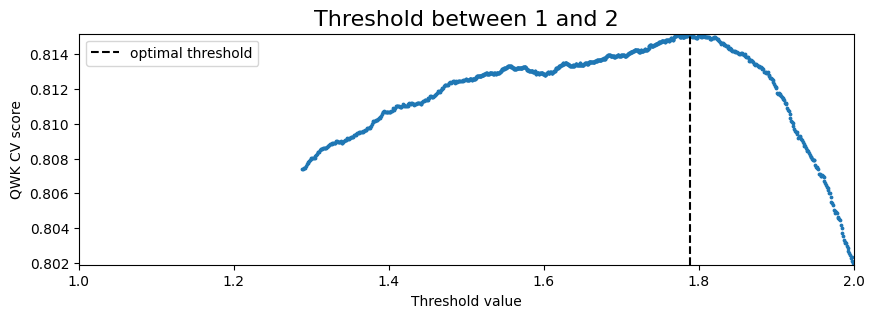

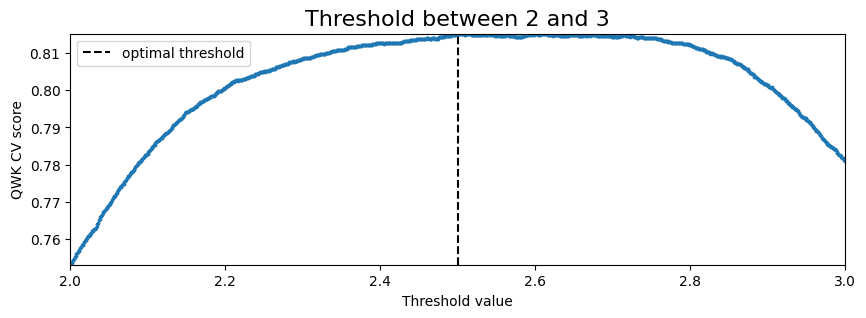

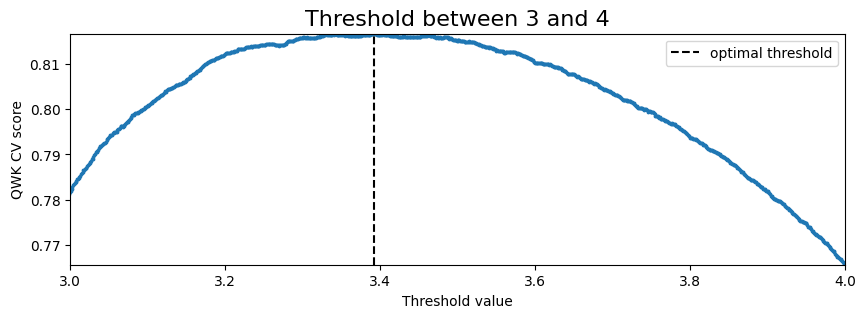

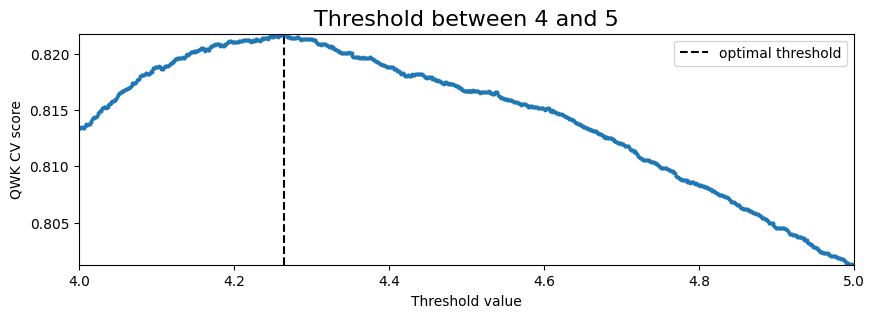

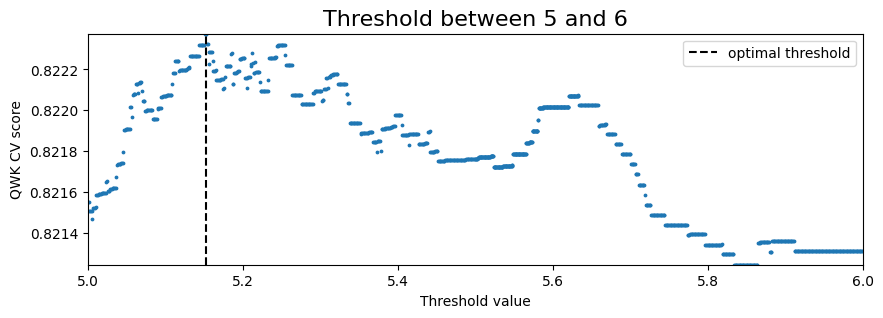

In [65]:
import matplotlib.pyplot as plt

diff = 0.5
for k in range(5):
    plt.figure(figsize=(10,3))
    plt.scatter(xs[k],ys[k],s=3)
    m = k+1.5
    plt.xlim((m-diff,m+diff))
    i = np.where( (np.array(xs[k])>m-diff)&(np.array(xs[k])<m+diff) )[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    plt.ylim((mn,mx))
    
    plt.plot([thresholds[k],thresholds[k]],[mn,mx],'--',
             color='black', label='optimal threshold')
    
    plt.title(f"Threshold between {k+1} and {k+2}",size=16)
    plt.xlabel('Threshold value',size=10)
    plt.ylabel('QWK CV score',size=10)
    plt.legend()
    plt.show()

# Create Submission CSV
We average our 15 fold predictions and apply optimal thresholds above to convert the 15 sets of regression predictions into 1 set of final target predictions.

In [66]:
test_preds = np.mean(test_preds,axis=1)
print('Test preds shape:', test_preds.shape )
print('First 3 test preds:',test_preds[:3] )

Test preds shape: (3,)
First 3 test preds: [2.1314387 2.5989494 3.9162765]


In [67]:
test_preds_pp = pd.cut(test_preds, [-np.inf] + thresholds + [np.inf], 
                       labels=[1,2,3,4,5,6]).astype('int32')
print('First 3 test preds after PP:',test_preds_pp[:3] )

First 3 test preds after PP: [2 3 4]


In [68]:
sub = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
sub["score"] = test_preds_pp
sub.score = sub.score.astype('int32')
sub.to_csv("submission.csv",index=False)
print("Submission shape", sub.shape )
sub.head()

Submission shape (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
